In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from typing import List, Tuple
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split

from utils import plot_decision_tree_importance, plot_player_value_trends


In [2]:
pdf_mvp = pd.read_csv("data/intermediate/model_data_prep.csv")

In [3]:
test_start = 2023

features = [
    "value_last_year",
    "age_last_year",
    # "pos_Attack",
    # "pos_Defender",
    # "pos_Goalkeeper",
    # "pos_Midfield"
]

# subpos_features = [col for col in pdf_mvp.columns if col.startswith("subpos_")]
# features += subpos_features

#test_players = pdf_mvp[pdf_mvp["year"] == test_start]["player_id"].unique()

train_df = pdf_mvp[(pdf_mvp["year"] < test_start)]
test_df = pdf_mvp[(pdf_mvp["year"] == test_start)]




In [4]:
def predict_future_values(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    prediction_years: List[int],
    features: List[str],
) -> tuple[pd.DataFrame, XGBRegressor, pd.Series]:
    """
    Predicts future player values for specified years using XGBoost.

    Args:
        train_df: Training DataFrame with features and target.
        test_df: Initial test DataFrame to predict from (starting year).
        prediction_years: List of years to predict, starting with the base year.
        features: List of feature column names to use.
        max_depth: Max depth for the XGBRegressor.

    Returns:
        Tuple of:
            - DataFrame with predicted values for all prediction years concatenated.
            - Trained XGBRegressor.
            - y_test from the base year (only valid for the first year).
    """

    target = "market_value_in_million_eur"

    # Train XGBoost model
    X_train = train_df[features]
    y_train = train_df[target]
    regressor = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        objective="reg:squarederror",
    )
    regressor.fit(X_train, y_train)

    predictions = []
    current_df = test_df.copy()

    for i, year in enumerate(prediction_years):
        X_test = current_df[features]
        current_df["predicted_value"] = regressor.predict(X_test)
        current_df["year"] = year

        if i == 0:
            y_test = current_df[target]
            rmse = root_mean_squared_error(y_test, current_df["predicted_value"])
            r2 = r2_score(y_test, current_df["predicted_value"])
            print(f"{year} RMSE: {rmse:.2f}")
            print(f"{year} R²: {r2:.3f}")

            fig = px.scatter(current_df, x="predicted_value", y=target, hover_data=["name", "age"])
            fig.show()
        else:
            current_df["age"] = current_df["age_last_year"] + 1

        current_df["age_last_year"] = current_df["age"]
        current_df["value_last_year"] = current_df["predicted_value"]

        predictions.append(current_df[["player_id", "year", "age", "predicted_value"]].copy())

        if i < len(prediction_years) - 1:
            pos_cols = [col for col in current_df.columns if col.startswith("pos_")]
            subpos_cols = [col for col in current_df.columns if col.startswith("subpos_")]
            static_cols = pos_cols + subpos_cols

            carry_cols = ["player_id", "value_last_year", "age", *static_cols]
            current_df = current_df[carry_cols].copy()
            current_df.rename(columns={"age": "age_last_year"}, inplace=True)

    # Concatenate all prediction DataFrames into one
    all_predictions_df = pd.concat(predictions, ignore_index=True)

    return all_predictions_df, regressor, y_test


In [5]:
forecast_df, regressor, y_test = predict_future_values(train_df, test_df, [2023, 2024, 2025, 2026, 2027, 2028], features)

2023 RMSE: 7.06
2023 R²: 0.802


In [6]:
# Merge with actual market values for evaluation

merged = forecast_df.merge(test_df[["player_id", "name"]], on=["player_id"], how="left")



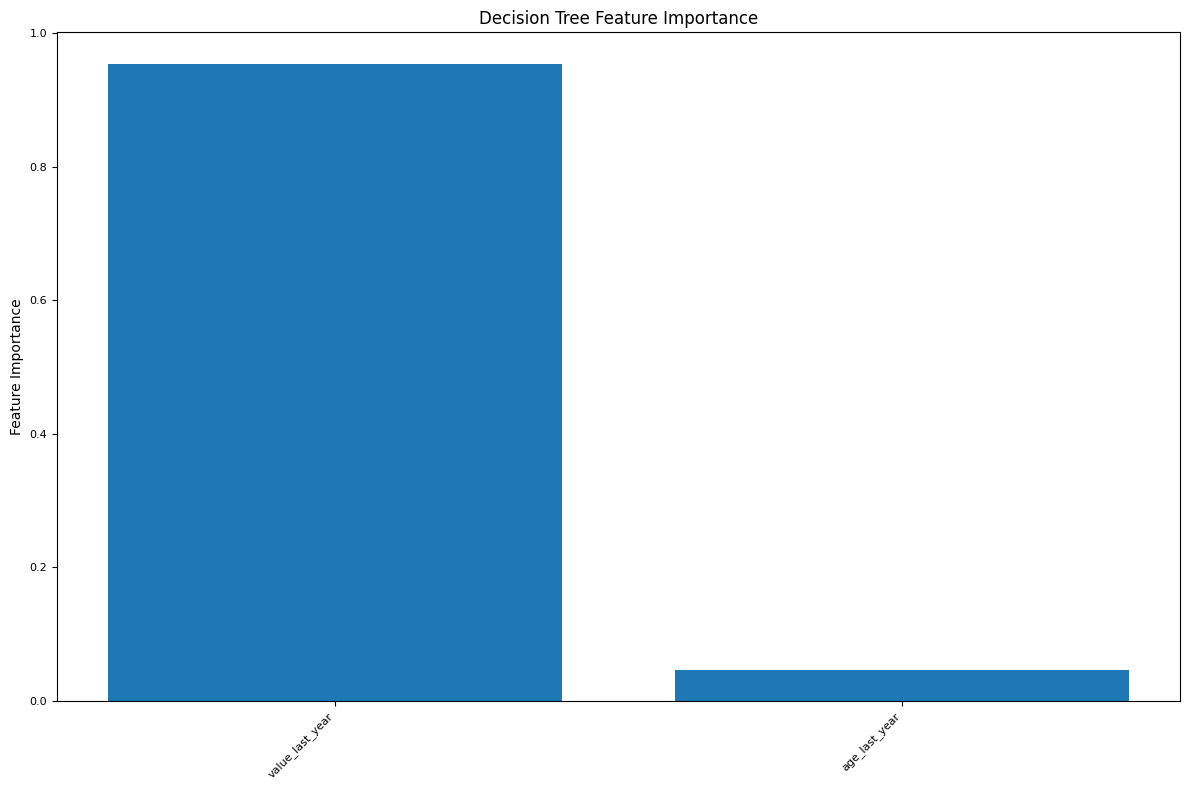

In [7]:
plot_decision_tree_importance(regressor, features)

In [ ]:
players = [418560, 357662, 565822, 859951, 148455, 274839, 542586]
plot_player_value_trends(train_df=train_df, merged_df=merged, player_ids=players)
